In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install bertopic

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

In [16]:
rawdata = pd.read_csv('/content/drive/My Drive/visual results/RepeatExperimentData/train.csv')
rawdata

,Order,text,final_topic,topics,label
0,723,a classic tycoon-style game with wacky and irr...,GameEvaluation_4,GameEvaluation,21
1,41,but honestly find the ones with the challenges...,DifficultyBalance_4,DifficultyBalance,15
2,565,however some of them get too repetitive like f...,Narrative_2,Narrative,35
3,1454,That was all I needed to see to know that I'm ...,GameEvaluation_5,GameEvaluation,21
4,1377,This game is way to good to pass up especially...,Virtual reality headset_5,Virtual reality headset,60
...,...,...,...,...,...
2215,682,Surviving Edged Weapons taught me a lot of val...,ImmersionRealism_5,ImmersionRealism,25
2216,1611,Steam refund simulator 2016 10/10 would refund...,Refund_2,Refund,49
2217,130,I would LOVE to see more aesthetic customizati...,Customisation_5,Customisation,12
2218,1647,does mess up the game for others as everythin...,InteractionSocialisation_2,InteractionSocialisation,28


In [17]:
docs=rawdata['text']
y = rawdata["label"]
y_names = rawdata["topics"]

In [18]:
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Create a fully supervised BERTopic instance
topic_model= BERTopic(
        umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model
)
topics, probs = topic_model.fit_transform(docs, y=y)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [19]:
# Preprocess Documents
documents = pd.DataFrame({"Document": docs,
                          "content":rawdata['text'],
                          "labels":rawdata["topics"],
                          "Topic": topics})


documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

In [20]:
mappings = topic_model.topic_mapper_.get_mappings()
mappings = {value: rawdata["label"][key] for key, value in mappings.items()}

In [24]:
df = topic_model.get_topic_info()
df["Class"] = df.Topic.map(mappings)
df

,Topic,Count,Name,Representation,Representative_Docs,Class
0,0,217,0_ai_friends_npcs_multiplayer,"[ai, friends, npcs, multiplayer, join, player,...","[They will shrug off hits that you can't, they...",42
1,1,106,1_overall_shooter_best_shows,"[overall, shooter, best, shows, tactical, genr...",[you can tell that this is not an English game...,17
2,2,103,2_bugs_crashes_save_performance,"[bugs, crashes, save, performance, fix, bug, l...",[I got sick of multiplayer bugs so I went to m...,21
3,3,87,3_graphics_photo_visuals_visually,"[graphics, photo, visuals, visually, taking, g...",[Most everything you can land on in NMS is bri...,52
4,4,77,4_difficulty_difficult_challenging_easy,"[difficulty, difficult, challenging, easy, cha...",[Staff being reduced from 4 types to 3 feels l...,13
...,...,...,...,...,...,...
57,57,6,57_2016_reveal_sceptical_redemption,"[2016, reveal, sceptical, redemption, incredib...",[ early on I was sceptical but now I'd fully a...,2
58,58,4,58_achievements_worrying_track_achievement,"[achievements, worrying, track, achievement, m...","[achievements (in-game, not the steam ones) un...",3
59,59,4,59_dota_esports_esport_successful,"[dota, esports, esport, successful, esoteric, ...",[the fact remains that this game is not one of...,28
60,60,3,60_town_owning_corner_own,"[town, owning, corner, own, allow, feeling, co...","[I got a town and now I love this game, ownin...",48


In [25]:
Class = [
"InteractionSocialisation",
"GameEvaluation",
"BugsCrashing",
"VisualAtmosphere",
"DifficultyBalance",
"Comparison",
"GameProgression",
"Engaging",
"Exploration",
"Update",
"ImmersionRealism",
"Novelty",
"Narrative",
"Controls",
"Developer",
"Audio",
"Platforms",
"Learnability",
"Combat mechanics",
"Management mechanics",
"Recommendation",
"Playtime and Gameplay length",
"PersonalInfluence",
"Creative mechanics",
"Customisation",
"Emotion",
"Guide and Tutorials",
"Development states",
"PriceQuality ratio",
"UIandUX",
"Players modification and Workshops",
"Movement mechanics",
"OnlineVideo",
"Survival mechanics",
"Virtual reality headset",
"Order state",
"In-game economic mechanics",
"Content filter",
"Mode settings",
"Graphics settings",
"Navigation and Maps",
"Review reception",
"In-game physics mechanics",
"Promotion strategy and Marketing collateral",
"Server",
"Social identity",
"Returning player",
"Accessibility options",
"Puzzle mechanics",
"Camera control",
"Refund",
"Game awareness duration",
"Language settings and Localisation",
"Simulation mechanics",
"Competition",
"Review experience",
"Wishlist and Notifications",
"Launch",
"Reward system",
"Esports competition",
"Ownership",
"Cheating"
]

In [ ]:
# value_counts = rawdata['topics'].value_counts()
# value_counts.to_csv('/content/value_counts.csv',header=True)


In [26]:
# df= pd.read_csv('/content/train-BERTopi53.csv')
df["Class"] = Class
df

,Topic,Count,Name,Representation,Representative_Docs,Class
0,0,217,0_ai_friends_npcs_multiplayer,"[ai, friends, npcs, multiplayer, join, player,...","[They will shrug off hits that you can't, they...",InteractionSocialisation
1,1,106,1_overall_shooter_best_shows,"[overall, shooter, best, shows, tactical, genr...",[you can tell that this is not an English game...,GameEvaluation
2,2,103,2_bugs_crashes_save_performance,"[bugs, crashes, save, performance, fix, bug, l...",[I got sick of multiplayer bugs so I went to m...,BugsCrashing
3,3,87,3_graphics_photo_visuals_visually,"[graphics, photo, visuals, visually, taking, g...",[Most everything you can land on in NMS is bri...,VisualAtmosphere
4,4,77,4_difficulty_difficult_challenging_easy,"[difficulty, difficult, challenging, easy, cha...",[Staff being reduced from 4 types to 3 feels l...,DifficultyBalance
...,...,...,...,...,...,...
57,57,6,57_2016_reveal_sceptical_redemption,"[2016, reveal, sceptical, redemption, incredib...",[ early on I was sceptical but now I'd fully a...,Launch
58,58,4,58_achievements_worrying_track_achievement,"[achievements, worrying, track, achievement, m...","[achievements (in-game, not the steam ones) un...",Reward system
59,59,4,59_dota_esports_esport_successful,"[dota, esports, esport, successful, esoteric, ...",[the fact remains that this game is not one of...,Esports competition
60,60,3,60_town_owning_corner_own,"[town, owning, corner, own, allow, feeling, co...","[I got a town and now I love this game, ownin...",Ownership


In [27]:
test = pd.read_csv('/content/drive/My Drive/visual results/RepeatExperimentData/test.csv')
test

,Order,text,final_topic,topics,label
0,2,It is a universe filled with countless planets...,Engaging_1,Engaging,17
1,3,It's a fantastic game and I would recommend to...,Recommendation_5,Recommendation,48
2,4,Fighting on- and off planet is as exciting as ...,Combat mechanics_1,Combat mechanics,6
3,4,Everything is autopiloted- Feels more casual t...,Movement mechanics_4,Movement mechanics,34
4,6,Be patient and follow the storyline as,Narrative_4,Narrative,35
...,...,...,...,...,...
947,1792,when a shooting actually occurs in a dance cl...,ImmersionRealism_5,ImmersionRealism,25
948,1793,the same snarky humor and I can easily lose tr...,Engaging_5,Engaging,17
949,1794,this is an awesome remake.,GameEvaluation_5,GameEvaluation,21
950,1795,There's an ok amount of customization for the ...,Customisation_4,Customisation,12


In [28]:
new_docs=test['text']
topics, probs = topic_model.transform(new_docs)


In [29]:
documents = pd.DataFrame({"Document": new_docs,
                          "Original_topic":test["topics"],
                          "Topic": topics})

In [30]:
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

In [31]:
documents

,Document,Original_topic,Topic
0,It is a universe filled with countless planets...,Engaging,8
1,It's a fantastic game and I would recommend to...,Recommendation,20
2,Fighting on- and off planet is as exciting as ...,Combat mechanics,0
3,Everything is autopiloted- Feels more casual t...,Movement mechanics,0
4,Be patient and follow the storyline as,Narrative,12
...,...,...,...
947,when a shooting actually occurs in a dance cl...,ImmersionRealism,10
948,the same snarky humor and I can easily lose tr...,Engaging,7
949,this is an awesome remake.,GameEvaluation,1
950,There's an ok amount of customization for the ...,Customisation,24


In [32]:
documents.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/test_predict_NF.csv')

In [38]:
Labels={
0:"InteractionSocialisation",
1:"GameEvaluation",
2:"BugsCrashing",
3:"VisualAtmosphere",
4:"DifficultyBalance",
5:"Comparison",
6:"GameProgression",
7:"Engaging",
8:"Exploration",
10:"Update",
11:"ImmersionRealism",
12:"Novelty",
13:"Narrative",
14:"Controls",
15:"Developer",
16:"Audio",
17:"Platforms",
18:"Learnability",
19:"Combat mechanics",
20:"Management mechanics",
21:"Recommendation",
22:"Playtime and Gameplay length",
23:"PersonalInfluence",
24:"Creative mechanics",
25:"Customisation",
26:"Emotion",
27:"Guide and Tutorials",
28:"Development states",
29:"PriceQuality ratio",
30:"UIandUX",
31:"Players modification and Workshops",
32:"Movement mechanics",
33:"OnlineVideo",
34:"Survival mechanics",
35:"Virtual reality headset",
36:"Order state",
37:"In-game economic mechanics",
38:"Content filter",
39:"Mode settings",
40:"Graphics settings",
41:"Navigation and Maps",
42:"Review reception",
43:"In-game physics mechanics",
44:"Promotion strategy and Marketing collateral",
45:"Server",
46:"Social identity",
47:"Returning player",
48:"Accessibility options",
49:"Puzzle mechanics",
50:"Camera control",
51:"Refund",
52:"Game awareness duration",
53:"Language settings and Localisation",
54:"Simulation mechanics",
55:"Competition",
56:"Review experience",
57:"Wishlist and Notifications",
58:"Launch",
59:"Reward system",
60:"Esports competition",
61:"Ownership",
62:"Cheating"
}

In [39]:
documents['topic_numerber']=documents['Topic']
documents_replace=documents.replace({"Topic": Labels})

In [40]:
documents_replace

,Document,Original_topic,Topic,topic_numerber
0,It is a universe filled with countless planets...,Engaging,Exploration,8
1,It's a fantastic game and I would recommend to...,Recommendation,Management mechanics,20
2,Fighting on- and off planet is as exciting as ...,Combat mechanics,InteractionSocialisation,0
3,Everything is autopiloted- Feels more casual t...,Movement mechanics,InteractionSocialisation,0
4,Be patient and follow the storyline as,Narrative,Novelty,12
...,...,...,...,...
947,when a shooting actually occurs in a dance cl...,ImmersionRealism,Update,10
948,the same snarky humor and I can easily lose tr...,Engaging,Engaging,7
949,this is an awesome remake.,GameEvaluation,GameEvaluation,1
950,There's an ok amount of customization for the ...,Customisation,Creative mechanics,24


In [41]:
documents_replace.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/test_predict_replaced_NF.csv')

In [42]:
documents_replace[documents_replace['Original_topic'] != documents_replace['Topic']]

,Document,Original_topic,Topic,topic_numerber
0,It is a universe filled with countless planets...,Engaging,Exploration,8
1,It's a fantastic game and I would recommend to...,Recommendation,Management mechanics,20
2,Fighting on- and off planet is as exciting as ...,Combat mechanics,InteractionSocialisation,0
3,Everything is autopiloted- Feels more casual t...,Movement mechanics,InteractionSocialisation,0
4,Be patient and follow the storyline as,Narrative,Novelty,12
...,...,...,...,...
945,and the trailers give you the impression that ...,Promotion strategy and Marketing collateral,DifficultyBalance,4
946,Thank you Hello Games Supporting this game tha...,Developer,Controls,14
947,when a shooting actually occurs in a dance cl...,ImmersionRealism,Update,10
950,There's an ok amount of customization for the ...,Customisation,Creative mechanics,24


In [43]:
from sklearn.metrics import confusion_matrix

y_actu = documents_replace['Original_topic']
y_pred = documents_replace['Topic']

In [44]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,9,Accessibility options,Audio,BugsCrashing,Camera control,Combat mechanics,Comparison,Content filter,Controls,Creative mechanics,...,Playtime and Gameplay length,PriceQuality ratio,Promotion strategy and Marketing collateral,Recommendation,Survival mechanics,UIandUX,Update,Virtual reality headset,VisualAtmosphere,All
Actual,,,,,,,,,,,,,,,,,,,,,
Accessibility options,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6
Audio,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,24
BugsCrashing,1,0,1,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,48
Camera control,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4
Cheating,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Update,17,0,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,30
Virtual reality headset,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,8,0,0,0,0,9
VisualAtmosphere,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,37,51


In [45]:
df_confusion =df_confusion[:62]
df_confusion= df_confusion.drop('All', axis=1)
df_confusion

Predicted,9,Accessibility options,Audio,BugsCrashing,Camera control,Combat mechanics,Comparison,Content filter,Controls,Creative mechanics,...,Players modification and Workshops,Playtime and Gameplay length,PriceQuality ratio,Promotion strategy and Marketing collateral,Recommendation,Survival mechanics,UIandUX,Update,Virtual reality headset,VisualAtmosphere
Actual,,,,,,,,,,,,,,,,,,,,,
Accessibility options,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Audio,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BugsCrashing,1,0,1,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Camera control,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Cheating,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UIandUX,1,0,0,0,0,1,2,0,0,0,...,0,0,5,0,0,0,0,0,0,4
Update,17,0,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
Virtual reality headset,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,8,0,0,0,0


In [46]:
y_true = []
y_pred = []
for actual_class in df_confusion.index:
    for predicted_class in df_confusion.columns:
        count = df_confusion.loc[actual_class, predicted_class]
        y_true.extend([actual_class] * count)
        y_pred.extend([predicted_class] * count)

f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score (Macro):", f1)

F1 Score (Macro): 0.08768305777015417


In [47]:
f1 = f1_score(y_true, y_pred, average='micro')
print("F1 Score (Micro):", f1)

F1 Score (Micro): 0.2605042016806723


In [48]:
df_confusion.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/test_predict_replaced_confusion_NF.csv')


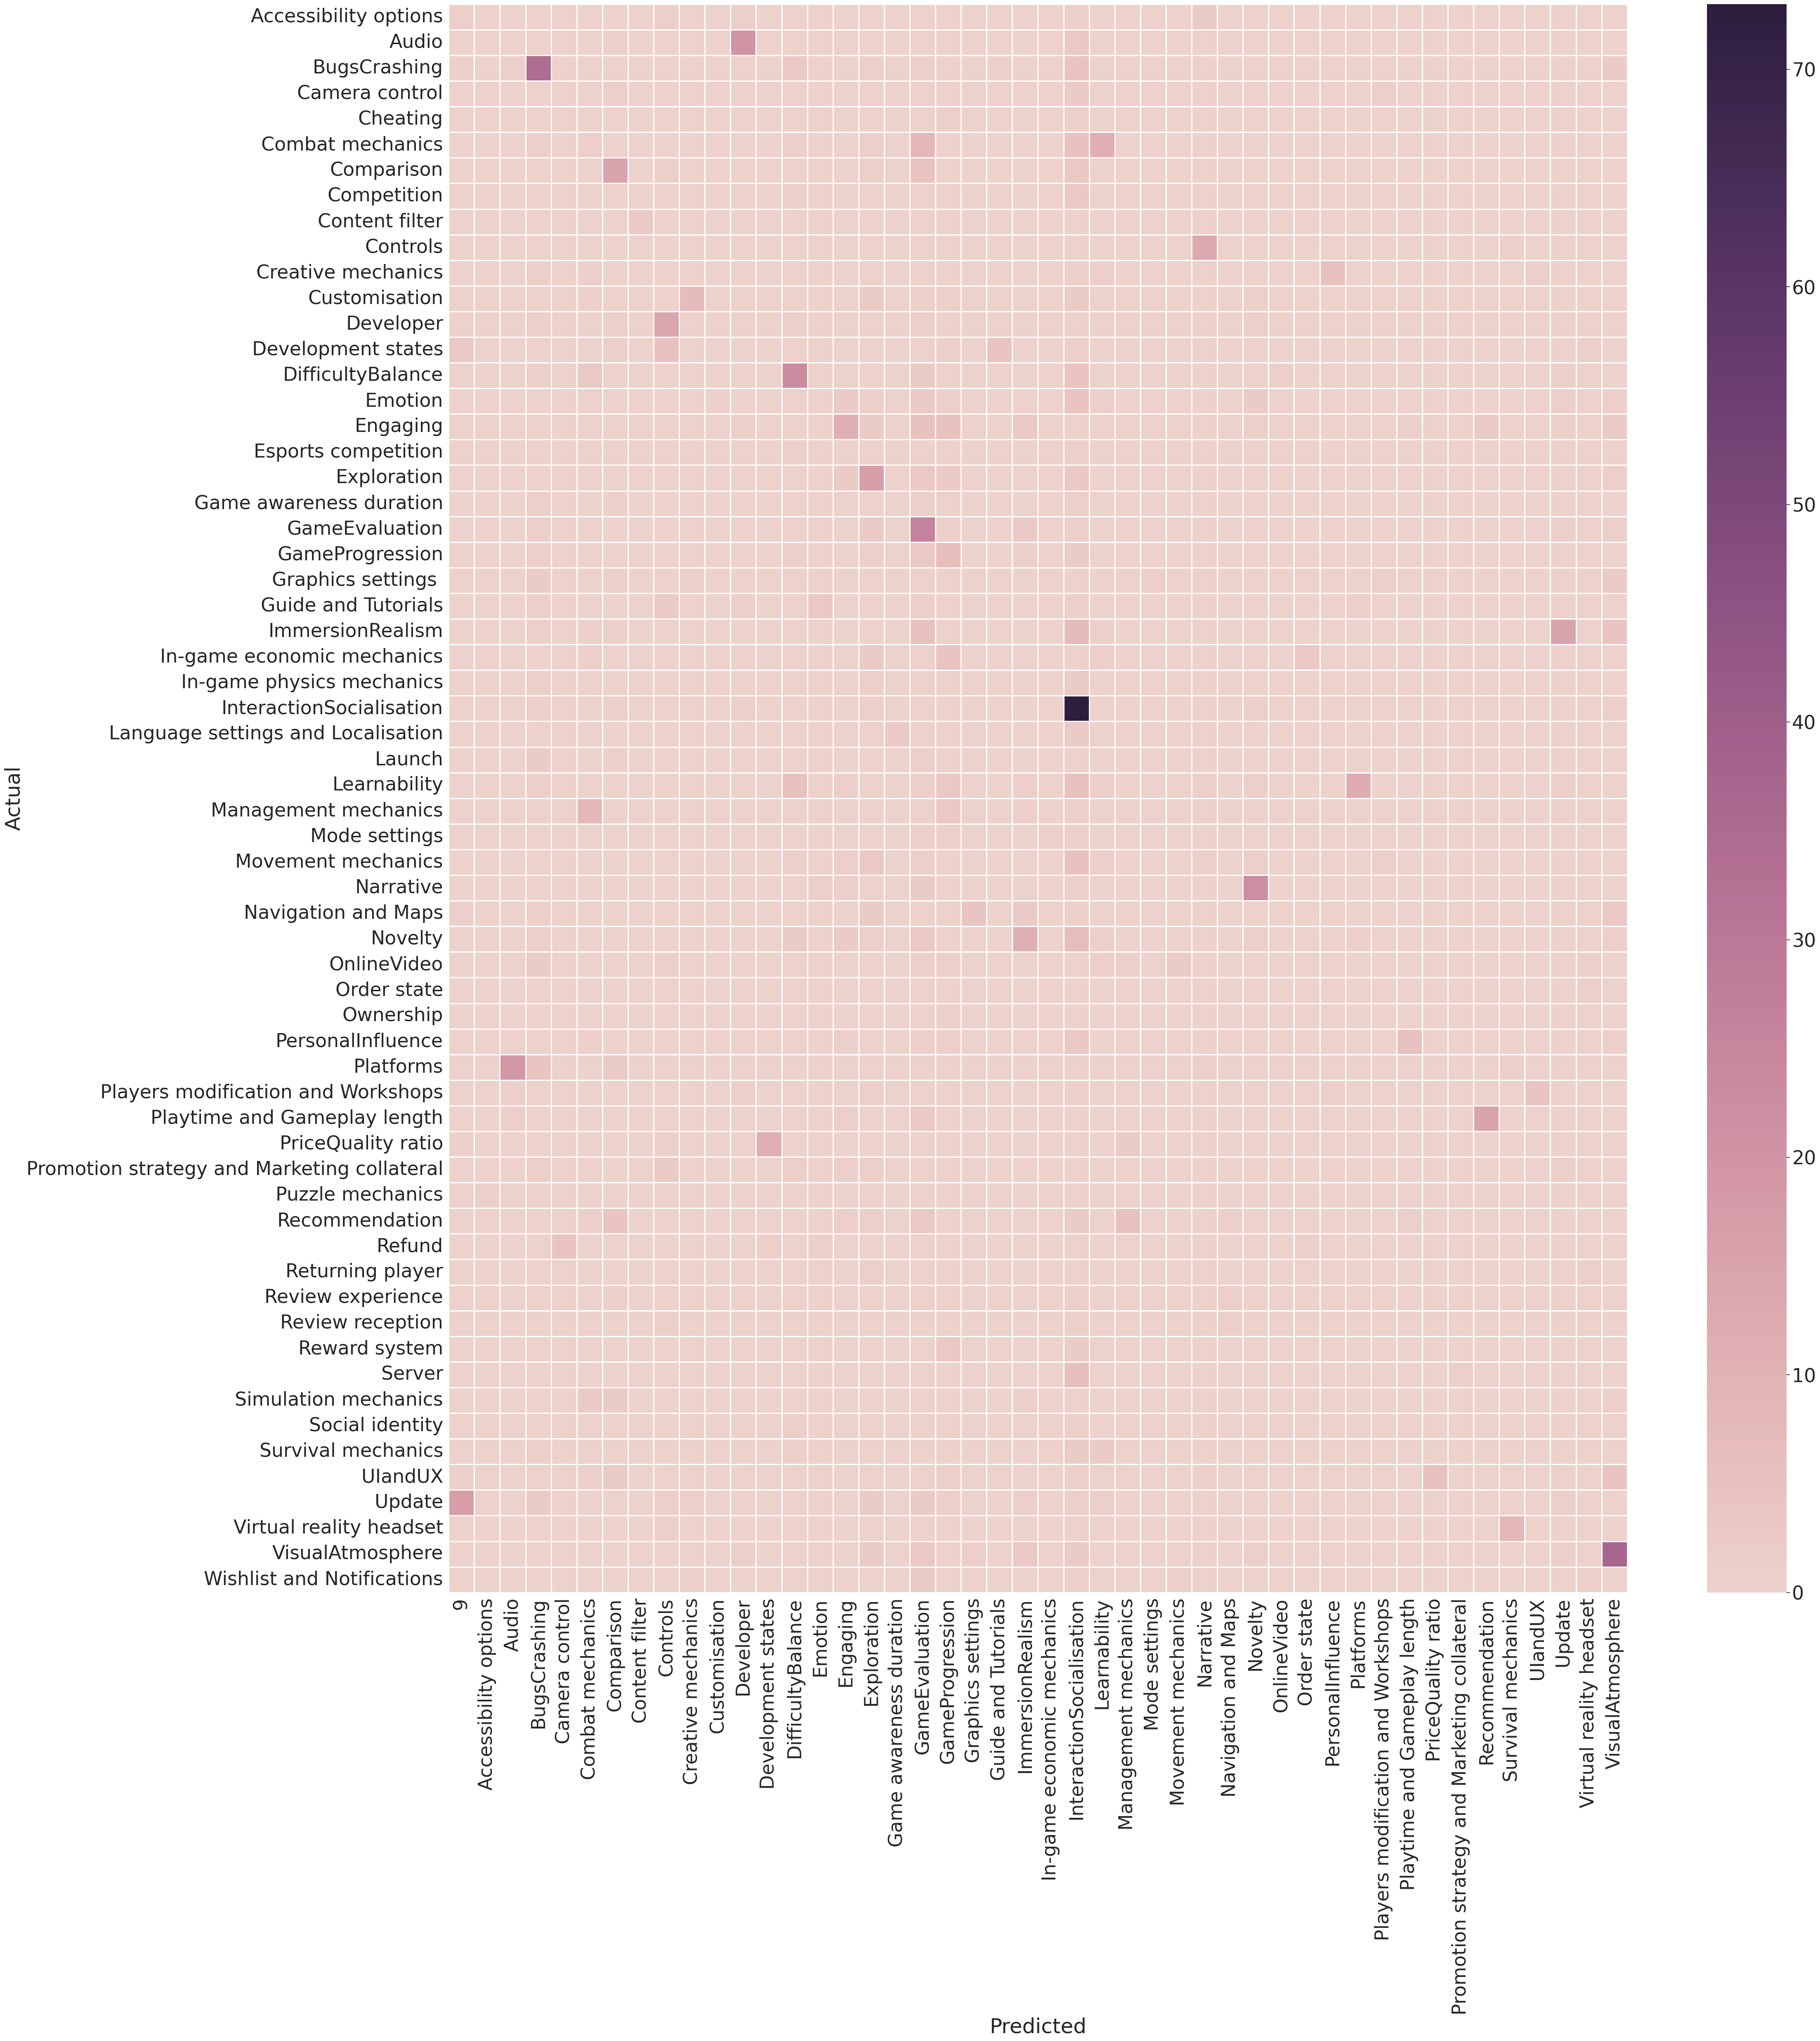

In [49]:
plt.figure(figsize = (50,50))

sn.set(font_scale=3) # for label size
sn.heatmap(df_confusion,  annot_kws={"size": 22}, cmap=sn.cubehelix_palette(as_cmap=True), fmt=".2f", square=True, linewidths=1, linecolor = "white")

plt.show()

In [50]:
from sklearn.preprocessing import minmax_scale
df_confusion[:] = minmax_scale(df_confusion)

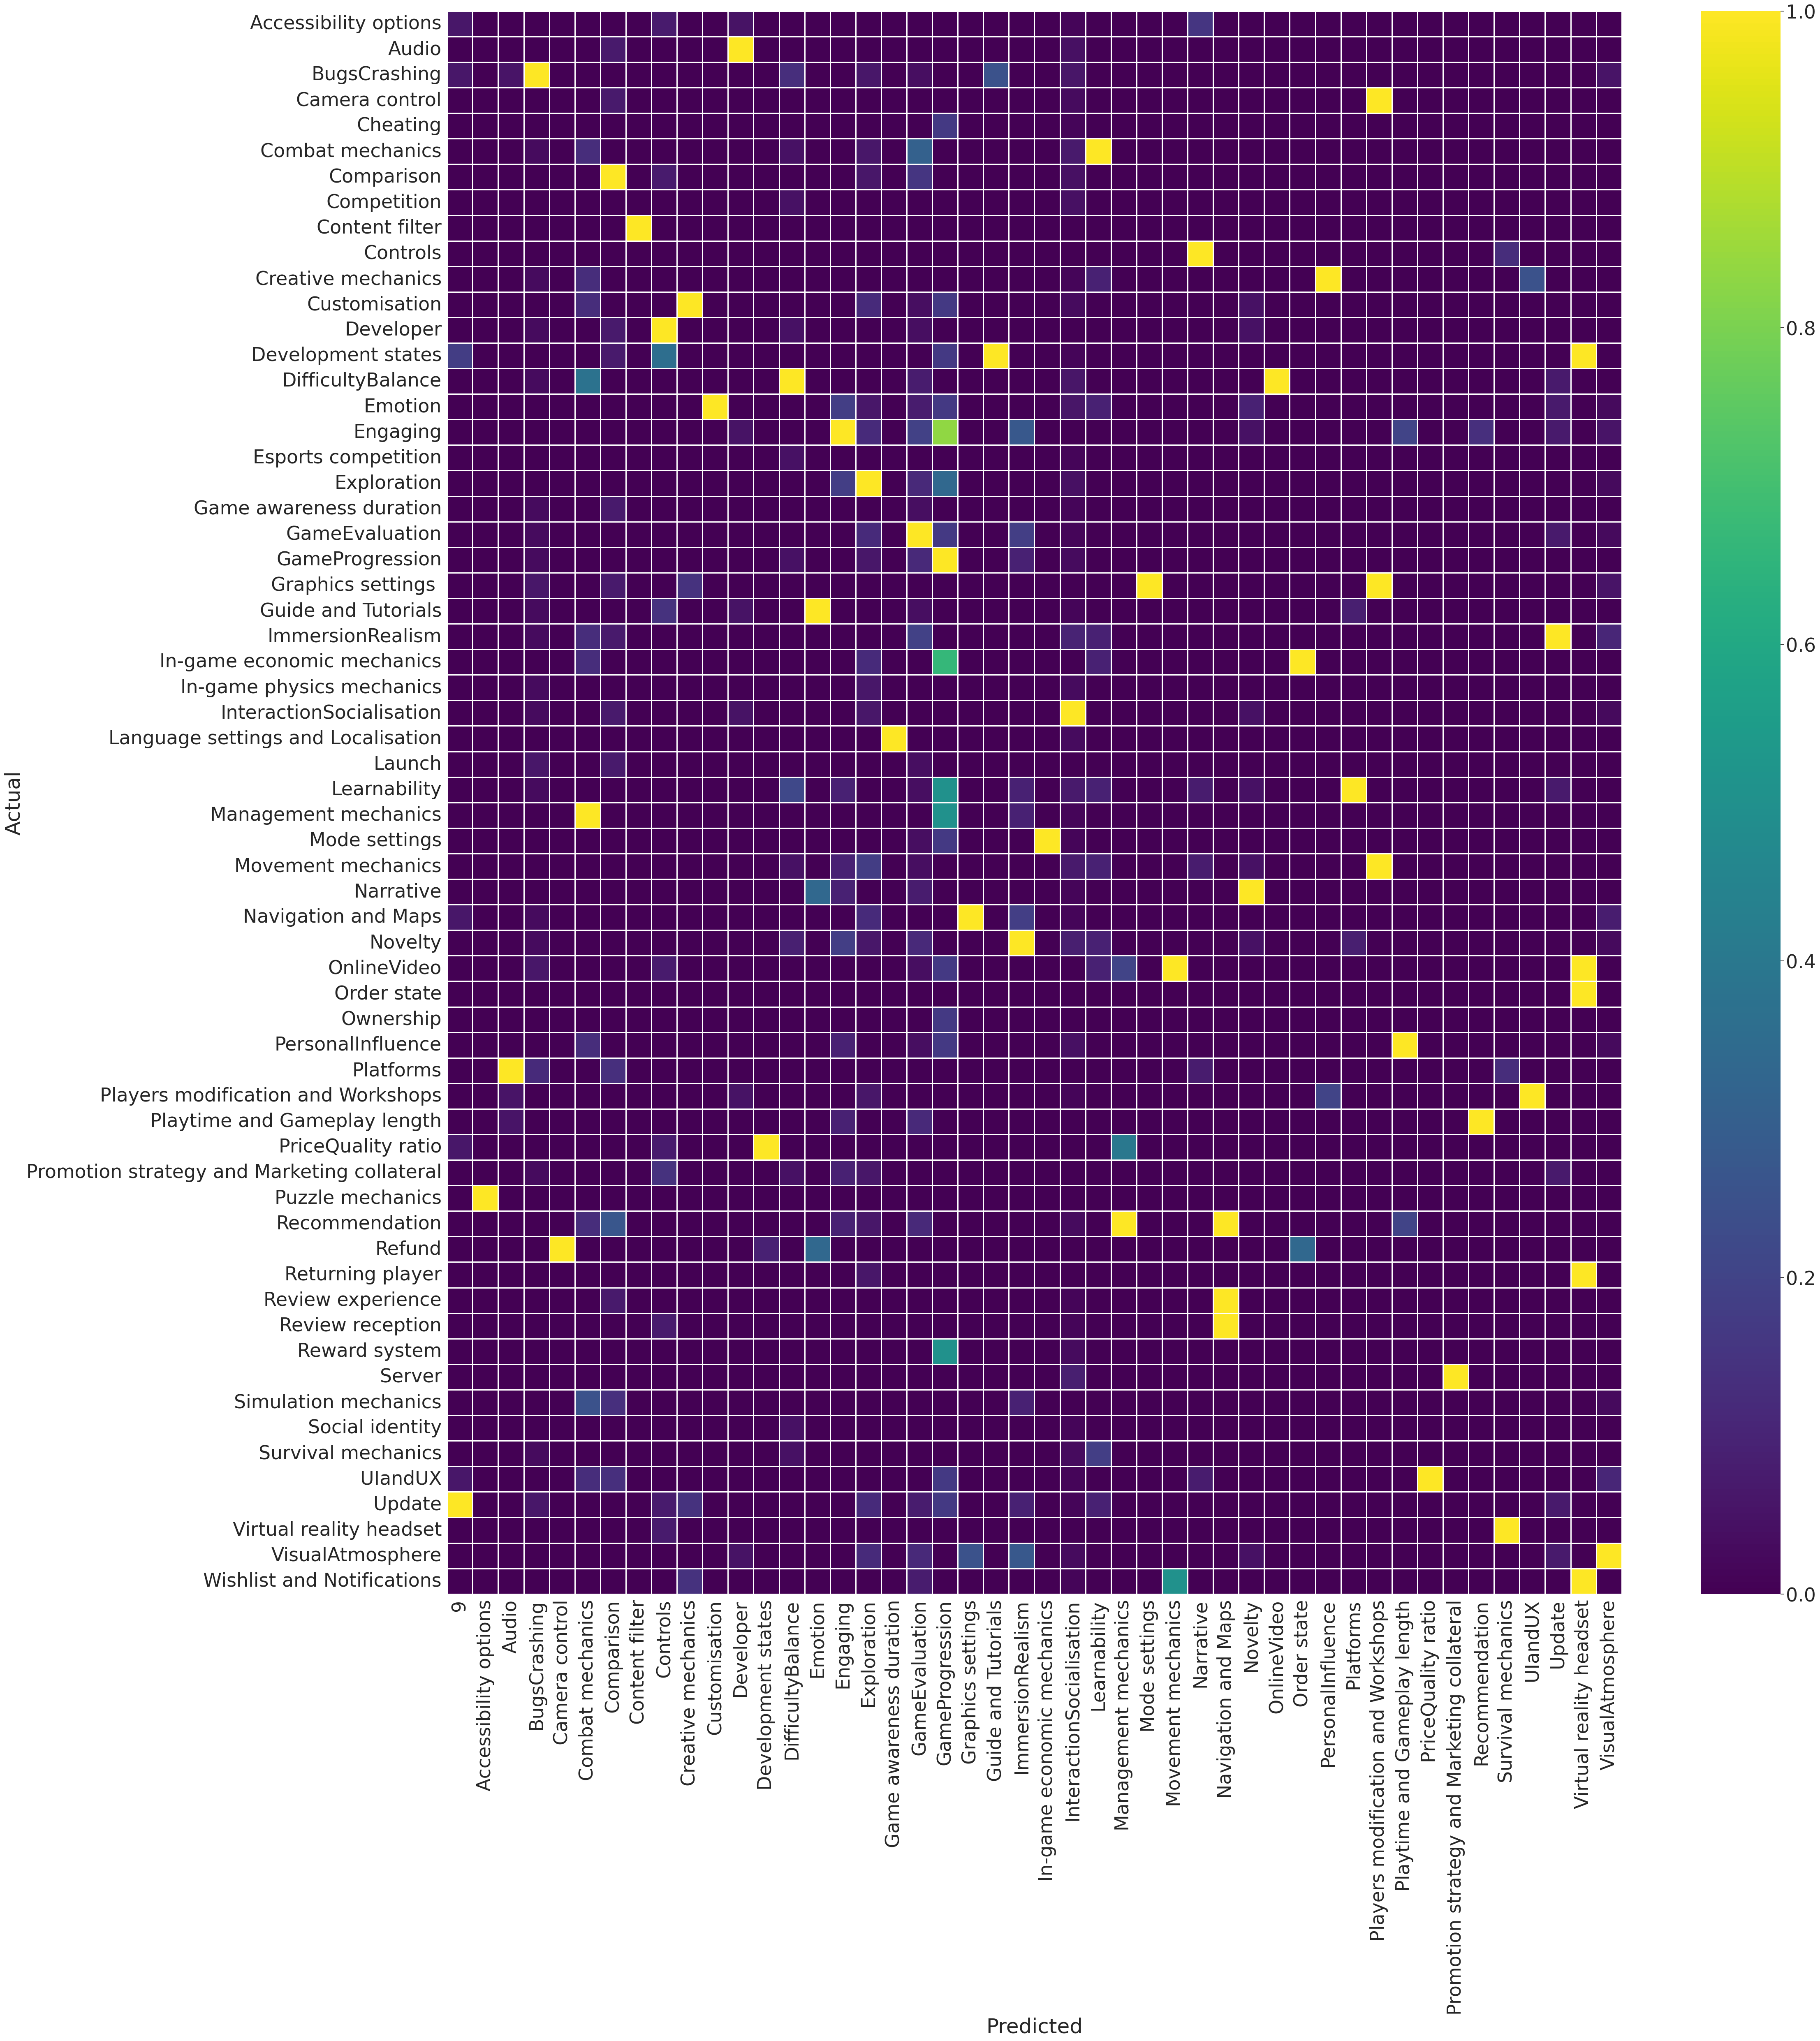

In [51]:
plt.figure(figsize = (50,50))

sn.set(font_scale=3) # for label size
sn.heatmap(df_confusion,  annot_kws={"size": 22}, cmap="viridis", fmt=".2f", square=True, linewidths=1, linecolor = "white")

plt.show()